# Tensorflow Model for Predicting Griewank, Ackley, Goldstein Functions

For my research I am making large-scale traffic/powergrid cosimulations.  Since these simulations take so long to run we aren't able to test every set of parameters that we would like for these simulations.  Thus we result to surrogate modeling to create a generalizable function for our simulation outputs where we don't have real data.  

To begin with I am starting by creating surrogate models/neuralnetwork models to predict some historical optimization test functions.  The griewank test function can be scaled to an arbitrary number of dimensions which allows you to practice fitting a surrogate model to it with the same number of dimensions/inputs as our simulation model has!

In [1]:
#All Imports for Tensorflow/Keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error,mean_absolute_error
#All other inputs
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
#from pykrige.rk import RegressionKriging
from sklearn.linear_model import LinearRegression
#from pykrige.ok import OrdinaryKriging
from sklearn.ensemble import RandomForestRegressor
#from smt.sampling_methods import LHS
import statistics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from random import randint

## Creating a Function to Select which test function you want to create data points for

In [2]:
def selectTargetFunc(funcName, dimArr=None, d1=None, d2=None):
    if funcName == 'griewank' and dimArr is None:
        yList = (d1 ** 2 / 4000) + (d2 ** 2 / 4000) - (np.cos(d1) * np.cos(d2 / np.sqrt(2))) + 1
        return yList
    elif funcName == 'griewank' and dimArr is not None:
        sum=0
        prod = 1
        for i in range(0,len(dimArr)):
            currX = dimArr[i]
            sum+=currX**2/4000
            prod = prod*np.cos(currX/np.sqrt(i+1))     #need +1 so that we don't get sqrt(0)
        yList = sum-prod+1
        return yList

    elif funcName == 'goldstein':
        d1 = dimArr[0]
        d2 = dimArr[1]
        yList = (1 + (d1 + d2 + 1) ** 2 * (
                19 - 14 * d1 + 3 * d1 ** 2 - 14 * d2 + 6 * d1 * d2 + 3 *
                d2 ** 2)) * (30 + (2 * d1 - 3 * d2) ** 2 * (
                18 - 32 * d1 + 12 * d1 ** 2 + 48 * d2 - 36 * d1 * d2 + 27 * d2 ** 2))
        return yList
    elif funcName == 'sphere':
        d1 = dimArr[0]
        d2 = dimArr[1]
        yList = d1**2+d2**2
        return yList
    elif funcName == 'ackley':
        a=20
        b=0.2
        c=2*np.pi
        sum1 = 0
        sum2 = 0
        for i in range(0,len(dimArr)):
            currX = dimArr[i]
            sum1+=currX**2
            sum2+=np.cos(c*currX)
        term1 = -a*np.exp(-b*np.sqrt(sum1/len(dimArr)))
        term2 = -np.exp(sum2/len(dimArr))
        yList=term1+term2+a+np.exp(1)
        return yList

## Define Parameters and pick your Optimization Test Function

In [3]:
numDimensions = 2   #for now keeping the number of dimensions to 2 so that the test functions can be visualized
size = 32.768
resolution=50
xBlock = []
for i in range(numDimensions):
    xBlock.append(np.linspace(-size,size,resolution))

xBlock = np.meshgrid(*xBlock)    #using the unpacking operator so that the meshgrid extends to higher dimensions
print(xBlock)

yResponse = selectTargetFunc('ackley',xBlock,None,None)


[array([[-32.768     , -31.43053061, -30.09306122, ...,  30.09306122,
         31.43053061,  32.768     ],
       [-32.768     , -31.43053061, -30.09306122, ...,  30.09306122,
         31.43053061,  32.768     ],
       [-32.768     , -31.43053061, -30.09306122, ...,  30.09306122,
         31.43053061,  32.768     ],
       ...,
       [-32.768     , -31.43053061, -30.09306122, ...,  30.09306122,
         31.43053061,  32.768     ],
       [-32.768     , -31.43053061, -30.09306122, ...,  30.09306122,
         31.43053061,  32.768     ],
       [-32.768     , -31.43053061, -30.09306122, ...,  30.09306122,
         31.43053061,  32.768     ]]), array([[-32.768     , -32.768     , -32.768     , ..., -32.768     ,
        -32.768     , -32.768     ],
       [-31.43053061, -31.43053061, -31.43053061, ..., -31.43053061,
        -31.43053061, -31.43053061],
       [-30.09306122, -30.09306122, -30.09306122, ..., -30.09306122,
        -30.09306122, -30.09306122],
       ...,
       [ 30.0930612

50
50


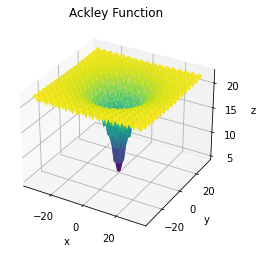

In [4]:
def graphTargetFunction(title, xlab, ylab, zlab,x1,y1,z1,x2=None,y2=None,z2=None,colormap=None, alph=None, edgeCol=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    if x2 is not None:
        ax.plot_trisurf(x1,y1,z1, cmap=colormap,edgecolor=edgeCol)
        ax.plot_trisurf(x2,y2,z2,alpha=alph)
        #ax.plot_trisurf(self.testX['d1'], self.testX['d2'], yPred, cmap='viridis', edgecolor='none')
    else:
        ax.plot_surface(x1,y1,z1, cmap=colormap, edgecolor=edgeCol, alpha=alph)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_zlabel(zlab)
    ax.set_title(title)
    plt.show()

print(len(yResponse))
print(len(yResponse[0]))
graphTargetFunction('Ackley Function','x','y','z',xBlock[0],xBlock[1],yResponse,colormap = 'viridis')


In [5]:
def createTrainingTesting(xBlock,yResponse):
    #print(xBlock)
    xDict = {}
    yDict = {}
    for i in range(len(xBlock)):
        colName = 'dim'+str(i)
        xDict[colName] = xBlock[i].reshape(-1)

    yDict['yResponse']=yResponse.reshape(-1)

    dfX = pd.DataFrame(data=xDict)
    dfY = pd.DataFrame(data=yDict)
    trainX,testX,trainY,testY = train_test_split(dfX,dfY,test_size=0.3)
    '''
    randInt = randint(1,100)
    trainX,testX = train_test_split(dfX,test_size=0.3,random_state=randInt)
    trainY,testY = train_test_split(dfY,test_size=0.3,random_state=randInt)
    '''

    visualize = pd.concat([dfX,dfY],axis=1)
    print(visualize)

    return trainX,trainY,testX,testY

In [6]:
trainX,trainY,testX,testY = createTrainingTesting(xBlock,yResponse)


           dim0    dim1  yResponse
0    -32.768000 -32.768  21.570311
1    -31.430531 -32.768  22.013209
2    -30.093061 -32.768  21.075872
3    -28.755592 -32.768  21.599467
4    -27.418122 -32.768  21.986116
...         ...     ...        ...
2495  27.418122  32.768  21.986116
2496  28.755592  32.768  21.599467
2497  30.093061  32.768  21.075872
2498  31.430531  32.768  22.013209
2499  32.768000  32.768  21.570311

[2500 rows x 3 columns]


Below I create a very basic neural network model that I will want to improve later which is able to give regression output instead of classification output which is what we are looking for with our research purposes.

In [7]:
model = Sequential()
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2021-09-20 13:35:23.318727: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
earlyStop = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=10)
#print(trainX)
#print(trainY)
model.fit(x=trainX,y=trainY,
         validation_data=(testX,testY),
         epochs=500, callbacks=[earlyStop])


Epoch 1/500


2021-09-20 13:35:23.399094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


55/55 [==============================] - 1s 3ms/step - loss: 523.4717 - val_loss: 376.8332
Epoch 2/500
55/55 [==============================] - 0s 1ms/step - loss: 466.4490 - val_loss: 320.0664
Epoch 3/500
55/55 [==============================] - 0s 1ms/step - loss: 391.9518 - val_loss: 282.0695
Epoch 4/500
55/55 [==============================] - 0s 1ms/step - loss: 356.1753 - val_loss: 247.5775
Epoch 5/500
55/55 [==============================] - 0s 1ms/step - loss: 320.1785 - val_loss: 210.7022
Epoch 6/500
55/55 [==============================] - 0s 1ms/step - loss: 265.4372 - val_loss: 174.5006
Epoch 7/500
55/55 [==============================] - 0s 1ms/step - loss: 233.2443 - val_loss: 139.1779
Epoch 8/500
55/55 [==============================] - 0s 1ms/step - loss: 210.5954 - val_loss: 115.0246
Epoch 9/500
55/55 [==============================] - 0s 1ms/step - loss: 192.4412 - val_loss: 96.2802
Epoch 10/500
55/55 [==============================] - 0s 1ms/step - loss: 173.2691 - v

55/55 [==============================] - 0s 1ms/step - loss: 63.8723 - val_loss: 20.6487
Epoch 82/500
55/55 [==============================] - 0s 1ms/step - loss: 63.7272 - val_loss: 19.7300
Epoch 83/500
55/55 [==============================] - 0s 1ms/step - loss: 65.4544 - val_loss: 18.5991
Epoch 84/500
55/55 [==============================] - 0s 1ms/step - loss: 59.2286 - val_loss: 16.9379
Epoch 85/500
55/55 [==============================] - 0s 1ms/step - loss: 57.9166 - val_loss: 15.7887
Epoch 86/500
55/55 [==============================] - 0s 2ms/step - loss: 57.5280 - val_loss: 15.3431
Epoch 87/500
55/55 [==============================] - 0s 2ms/step - loss: 55.4508 - val_loss: 15.3759
Epoch 88/500
55/55 [==============================] - 0s 2ms/step - loss: 53.6018 - val_loss: 15.5356
Epoch 89/500
55/55 [==============================] - 0s 1ms/step - loss: 52.9428 - val_loss: 13.7649
Epoch 90/500
55/55 [==============================] - 0s 1ms/step - loss: 50.3539 - val_loss: 1

<AxesSubplot:>

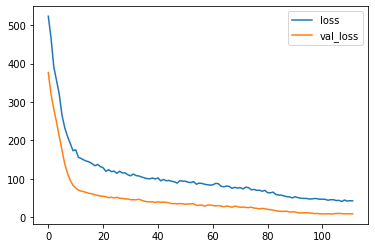

In [9]:
modelLoss = pd.DataFrame(model.history.history)
modelLoss.plot()

In [10]:
predictions = model.predict(testX)
mean_absolute_error(testY,predictions)

2.8046255729364336

In [11]:
np.sqrt(mean_squared_error(testY,predictions))

2.997375398197636

## Plotting the error over the region of interest for the test function

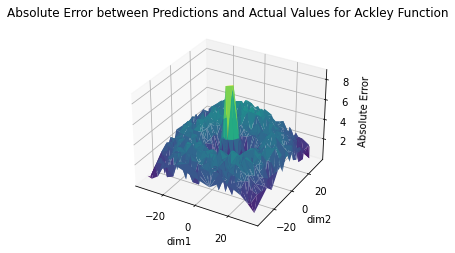

Hello 750
[[17.339672 ]
 [18.94435  ]
 [18.674372 ]
 [16.369783 ]
 [19.5283   ]
 [18.90246  ]
 [18.820337 ]
 [17.37421  ]
 [19.53688  ]
 [18.699669 ]
 [16.830496 ]
 [15.907316 ]
 [18.712025 ]
 [17.0686   ]
 [17.067541 ]
 [18.200169 ]
 [15.620504 ]
 [19.287598 ]
 [20.596172 ]
 [17.838951 ]
 [19.386961 ]
 [18.301304 ]
 [15.499329 ]
 [19.692549 ]
 [15.778936 ]
 [18.815237 ]
 [18.336536 ]
 [17.552034 ]
 [20.708239 ]
 [15.421267 ]
 [17.409136 ]
 [17.581663 ]
 [16.152353 ]
 [17.87403  ]
 [16.783957 ]
 [19.228916 ]
 [16.821281 ]
 [18.342047 ]
 [17.025848 ]
 [16.3362   ]
 [18.795044 ]
 [17.02629  ]
 [15.470324 ]
 [15.46386  ]
 [19.070992 ]
 [16.930311 ]
 [15.373898 ]
 [19.087479 ]
 [18.48837  ]
 [15.486519 ]
 [16.888866 ]
 [20.17491  ]
 [16.171806 ]
 [18.614265 ]
 [17.31735  ]
 [19.434753 ]
 [20.282518 ]
 [20.05973  ]
 [15.416609 ]
 [19.535944 ]
 [18.677698 ]
 [17.96998  ]
 [18.517427 ]
 [16.10234  ]
 [16.569025 ]
 [15.83523  ]
 [17.460636 ]
 [19.165915 ]
 [19.88228  ]
 [18.865831 ]
 [16.32836

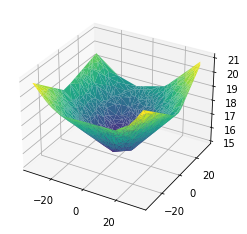

In [12]:
errorVals = abs(testY-predictions)
#print(errorVals)
#print(testX['dim0'])
#print(testX['dim1'])
#print(errorVals['yResponse'])
#graphTargetFunction('hello','x','y','z',testX['dim0'],testX['dim1'],errorVals['yResponse'],colormap = 'viridis')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(testX['dim0'],testX['dim1'],errorVals['yResponse'], cmap='viridis')
plt.title("Absolute Error between Predictions and Actual Values for Ackley Function")
plt.xlabel('dim1')
plt.ylabel('dim2')
ax.set_zlabel('Absolute Error')
plt.show()

print(f"Hello {len(predictions)}")
print(predictions)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(testX['dim0'],testX['dim1'],predictions.reshape(-1), cmap='viridis')
plt.show()
